<a href="https://colab.research.google.com/github/Kudryai/DataAnalyst/blob/main/KudryavtsevA.I_EDA-%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Подготовка и иследование датасета**

**Изучение датасета - оценка его размера и наличие в нём пропусков.**

---






*   Импортирование необходимых библиотек и датасета для работы

In [39]:
!gdown --id 1NWH38NQDZd2uQ-Wa2eYUK-OdSiJmY5Nf

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NWH38NQDZd2uQ-Wa2eYUK-OdSiJmY5Nf
To: /content/regionroles1_1.csv
100% 429M/429M [00:02<00:00, 188MB/s]


In [40]:
!gdown --id 19DPB_4V5omPRKwG9PYT2wiQn3xf1yCaV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19DPB_4V5omPRKwG9PYT2wiQn3xf1yCaV
To: /content/regionroles2.csv
100% 444M/444M [00:02<00:00, 185MB/s]


*  Для более качественного разведочного анализа, использую 2 датасета предоставленные заказчиком.

In [41]:
from math import nan
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re

 # Так как файлы достаточно весомые, загружаем в DataFrame порциями.
chunk = pd.read_csv('regionroles1_1.csv',delimiter=';', chunksize = 10000)
df1 = pd.concat(chunk)
chunk2 = pd.read_csv('regionroles2.csv',delimiter=';', chunksize = 10000)
df2 = pd.concat(chunk2)

*    Удаляем не нужные нам колонки, оставляем необходимые:

1)  название вакансии (name)

2)  описание вакансии (description)

3)  регион вакансии (area)

4)  дата размещения вакансии (published_at)

5)  ключевые навыки (key_skills)

6)  специализация (specialization.profarea_name)

7)  подспециализация (specialization)



In [42]:
df1.drop(df1.columns[[0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 14, 15, 16, 17, 18, 
                      19, 20, 21, 22, 23, 24, 25, 26, 27,29,32, 33]], axis = 1, inplace=True)
df2.drop(df2.columns[[0, 1, 2, 4, 5, 6, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                      22, 23, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                      41, 42, 43, 44, 45, 46, 47, 48, 49, 50]], axis = 1, inplace=True)

*   Объединяем два DataFrame в один, назовём его 'df'

In [43]:
frames = [df1, df2]
df = pd.concat(frames,ignore_index=True)

* Изучение датасета

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146038 entries, 0 to 146037
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   name             146038 non-null  object
 1   area             146037 non-null  object
 2   salary           78464 non-null   object
 3   published_at     146036 non-null  object
 4   description      146038 non-null  object
 5   key_skills       146037 non-null  object
 6   specializations  146038 non-null  object
dtypes: object(7)
memory usage: 7.8+ MB


In [45]:
df.dropna(inplace=True)  # Производим чистку

* Так же при анализе данных были выявленны вакансии не в IT сфере, как требует от нас заказчик. Поэтому чистим нашу таблицу дальше. Отсеиваем только IT специальности с помощью регулярных выражений, те вакансии которые не прошли помечаем "DELETE" и далее их удалим.



In [46]:
def clear_proff(name):
    stop_proff = ["Младший специалист ручного тестирования","Руководитель проекта",
                  'Руководитель отдела персонала', 'Ведущий программист 1С', 
                  'Ведущий программист 1C','Руководитель проектов']
    clear_name_proff = re.findall(r'.рограм|QA|.ести.|.ata|разраб...|analy...|анали...|IT|.evelop.|.ystem|.ехноло|.naly|progra..|.истемн|ИТ|.икросерв|ит|', name)
    if any(clear_name_proff) and name not in stop_proff:
        if name in "Программист 1С":
            return 'Программист 1C'
        return name
    return 'DELETE'

df['Должность'] = df['name'].apply(clear_proff)


*   Фильтруем, обновляем наш главный 'df'. Теперь только IT

In [47]:
district = ['DELETE']
filter = ~(df['Должность'].isin(district))
df = df[filter]


* Очистка колонки Description - Описание вакансии

In [48]:
def descrip_clean(text):
    return re.sub(r'[a-z<>/]','',text)

df['Описание_вакансии'] = df['description'].apply(descrip_clean)

* Очистка Специализации и Подспециализации

In [49]:
def subspecialization_clean(subspec):
  try:
    patterx = json.loads(subspec.replace("'", '"'))
    return patterx[0]['profarea_name']
  except:
    return nan

df['Подспециализация'] = df['specializations'].apply(subspecialization_clean)
df['Подспециализация'].dropna(inplace = True)

In [50]:
def specialization_clean(text):
  try:
    patterx = json.loads(text.replace("'", '"'))
    spec_clean_result = []
    for num in patterx:
        spec_clean_result.append(num['name'])
    return spec_clean_result
  except:
    return nan

df['Специализация'] = df['specializations'].apply(specialization_clean)
df['Специализация'].dropna(inplace = True)

* Приведение заработной платы к типу данных INTEGER

>   В связи с тем что в файле указана зарплата от "сумма" до "сумма", принял решение собрать данные зарплаты и привести к среднему значению.



In [51]:
def salary_int(price):
    USD_currency = 60
    if type(price) != float: 
        if 'USD' in price:
            price = re.sub('\D+', ' ', price)
            price = [int(i)*USD_currency for i in price.split()] 
            return sum(price)//len(price)
        price = re.sub('\D+', ' ', price)
        price = [int(i) for i in price.split()] 
        if sum(price)//len(price) < 15279: # Не забываем что МРОТ (15279руб на 2022г.)
            return nan
        return sum(price)//len(price)
    else:
        return nan


df['Средняя_зарплата'] = df['salary'].apply(salary_int)


In [52]:
district1 = [nan]
filter2 = ~(df['Средняя_зарплата'].isin(district1))
df = df[filter2]

In [53]:
df['Средняя_зарплата'] = df['Средняя_зарплата'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30189 entries, 1 to 145990
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               30189 non-null  object
 1   area               30189 non-null  object
 2   salary             30189 non-null  object
 3   published_at       30189 non-null  object
 4   description        30189 non-null  object
 5   key_skills         30189 non-null  object
 6   specializations    30189 non-null  object
 7   Должность          30189 non-null  object
 8   Описание_вакансии  30189 non-null  object
 9   Подспециализация   30084 non-null  object
 10  Специализация      30090 non-null  object
 11  Средняя_зарплата   30189 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 3.0+ MB


* Приведение колонки *area* в читабельный вид.

Переходим к следующей колонке, 'area'. Здесь так же наблюдаем много лишних символов, нам будет не удобно собирать статистику по кол-ву открытых вакансий в разных городах. Поэтому давайте приведем в читабельный вид данную колонку.

In [54]:
def area_clean(area): # очистка региона, города от лишних символов
    return ''.join(re.findall(r'[А-Я-а-я]',area))

df['Город'] = df['area'].apply(area_clean)

* Очистка колонки 'key_skills* 

Данную колонку записываем в type - list, так же из за проблем с открытием в формате json, используем try\except и в ручном режиме чистим с помощью регулярных выражений.

In [55]:
def clean_skills(text):
    stop_skills = ['1С программирование','Управление проектами',
                   'Английский язык','Работа в команде',
                   'Настройка ПК','Грамотная речь','Настройка ПО']
    try:
        pattern = json.loads(text.replace("'", '"'))
        if len(pattern)>0:
            result = []
            for i in range(len(pattern)):
              if pattern[i]['name'] not in stop_skills:
                result.append(pattern[i]['name'])
            return result
        return nan
    except:
        text = re.sub(r"[{}['a-z,]","",text[:-1]).split(':')
        return text[1:]
        

df['Навыки'] = df['key_skills'].apply(clean_skills)

# **2. Анализ числовых данных**

*   Настройка стиля графиков

In [56]:
plt.rcParams['axes.facecolor'] = '#e0defa'
colors = sns.color_palette('rocket')[0:5]
sns.set_palette('flare')
sns.set_context("notebook")
sns.color_palette('rocket')[0:10]

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

* Какая самая высокая и низкая зарплаты? И другие данные по этой колонке

In [57]:
salary = df['Средняя_зарплата']

all_set_salar = salary.describe()

print(f'''Анализ колонки "Зарплата"  
{round(all_set_salar)}''')

Анализ колонки "Зарплата"  
count      30189.0
mean      114396.0
std       103970.0
min        15494.0
25%        50600.0
50%        90000.0
75%       150000.0
max      5150000.0
Name: Средняя_зарплата, dtype: float64


* Boxplot для данных по зарплате.

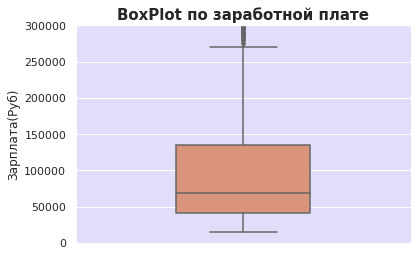

In [58]:
salary_numbers = df['Средняя_зарплата'].value_counts()
sns.boxplot(y=salary_numbers.index, data = df)
plt.xlim(-1, 1)
plt.title('BoxPlot по заработной плате',fontweight="bold",fontsize=15)
plt.ylabel('Зарплата(Руб)')
plt.ylim(0, 300000)
plt.show()

* Гистограмма по зарплате и кол-во вакансий

(15000.0, 200000.0)

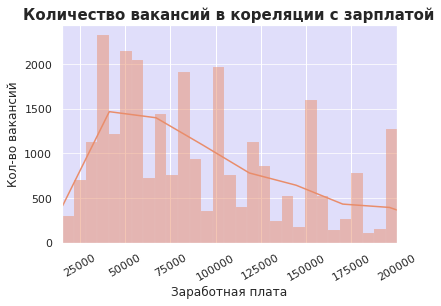

In [59]:
salar = df['Средняя_зарплата']

sns.histplot(data=salar, x=df['Средняя_зарплата'], kde=True, palette='flary')
plt.xticks(rotation=30)
plt.ylabel('Кол-во вакансий')
plt.title('Количество вакансий в кореляции с зарплатой',fontweight="bold",fontsize=15)
plt.xlabel('Заработная плата')
plt.grid(axis='y', alpha=0.75)
plt.xlim(15000, 200000)

* Столбчатый график по дате опубликованных вакансий

<function matplotlib.pyplot.show(*args, **kw)>

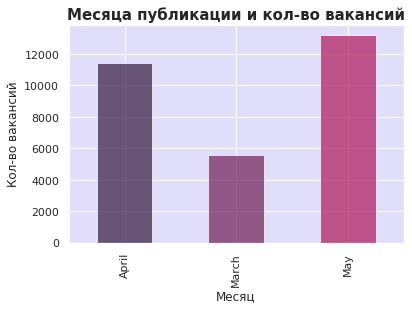

In [60]:
df['Дата'] = df['published_at'].astype('datetime64')

dates = df['Дата'].groupby(df['Дата'].dt.strftime('%B')).count().plot(
    kind ="bar", alpha=0.7, color=colors)
plt.title('Месяца публикации и кол-во вакансий',fontweight="bold",fontsize=15)
plt.xlabel('Месяц')
plt.ylabel('Кол-во вакансий')
plt.show

# ВЫВОДЫ:

1.   Зарплаты в нашем датасете варьируются 51888руб. до 150000 руб., медианная зарплата составляет 90000 рублей. По гистограмме видно, что есть 5 точек, где больше всего вакансий и зарплаты составляют ( 35000руб, 50000руб, 60000руб, 100000руб, 150000руб) соответственно.
2.   Наш датасет содержит вакансии большинство которых опубликовано в Апреле и Мае 2022



# **3. Анализ категориальных данных**

* Проанализируем топ - 5 городов в которых открыто больше всего вакансий

In [61]:
df['Город'].value_counts()[:5]
df['Город'].describe()

count      30189
unique       664
top       Москва
freq        6379
Name: Город, dtype: object

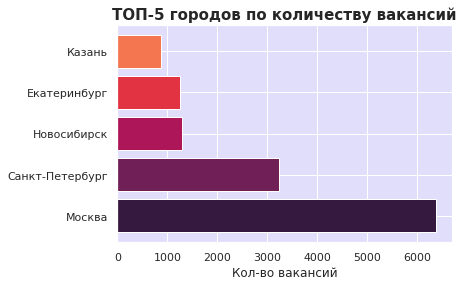

In [62]:
cits = df['Город'].value_counts()
plt.title('ТОП-5 городов по количеству вакансий',fontweight="bold",fontsize=15)
plt.barh(cits.index[:5], cits[:5], color=colors)
plt.xlabel('Кол-во вакансий')
plt.show()




* Проанализируем самую часто встречающуюся должность в вакансиях ТОП 10

In [63]:
df['Должность'].value_counts()[:10]

Системный администратор            2478
Программист 1C                     2286
Инженер-программист                 490
Аналитик                            323
Системный аналитик                  229
Бизнес-аналитик                     186
Frontend-разработчик                162
Ведущий системный администратор     157
Web-разработчик                     132
Ведущий инженер-программист         112
Name: Должность, dtype: int64

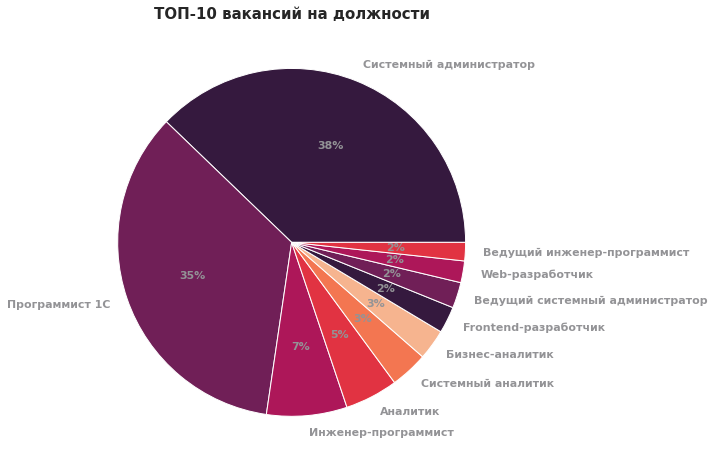

In [64]:
proff = df['Должность'].value_counts()
colors = sns.color_palette('rocket')[0:10]

plt.figure(figsize=(8, 8))
plt.pie(proff[:10], labels = proff.index[:10], colors = colors,
        autopct='%.0f%%', 
        textprops=dict(color='#939396', weight='bold', fontsize=11))
plt.title('ТОП-10 вакансий на должности',fontweight="bold",fontsize=15)
plt.show()

* Проанализируем топ 15 необходимых навыков которые требует работодатель

In [65]:
df['Навыки'].explode().value_counts()[:15]

Git                              3645
SQL                              3237
JavaScript                       2707
Linux                            2465
1С: Предприятие 8                2180
PHP                              1984
MySQL                            1956
ООП                              1723
HTML                             1627
PostgreSQL                       1597
CSS                              1426
Python                           1370
Настройка сетевых подключений    1254
Java                             1140
Аналитическое мышление           1073
Name: Навыки, dtype: int64

[]

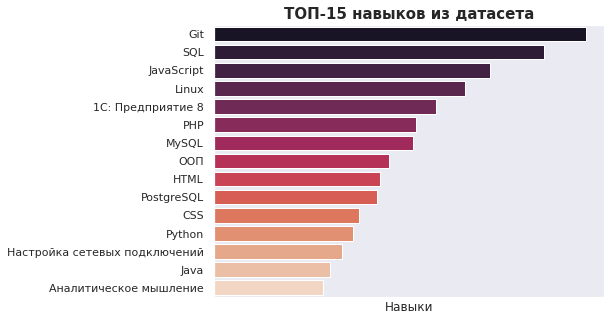

In [66]:
skill = df['Навыки'].explode().value_counts()
# sns.set_theme(style="white", context="talk")
sns.set_theme(style="darkgrid", palette="rocket")
f, ax1 = plt.subplots(1, figsize=(7, 5), sharex=True)
x = skill.index[:15]
y1 = skill[:15]


sns.barplot(y=x, x=y1, palette="rocket")
plt.title('ТОП-15 навыков из датасета',fontweight="bold",fontsize=15)
plt.xticks(rotation= 90)
plt.setp(f.axes, xticks=[])

* Проанализируем в какой подспециализации требуются IT специалисты:

In [67]:
subspec = df['Подспециализация'].value_counts()

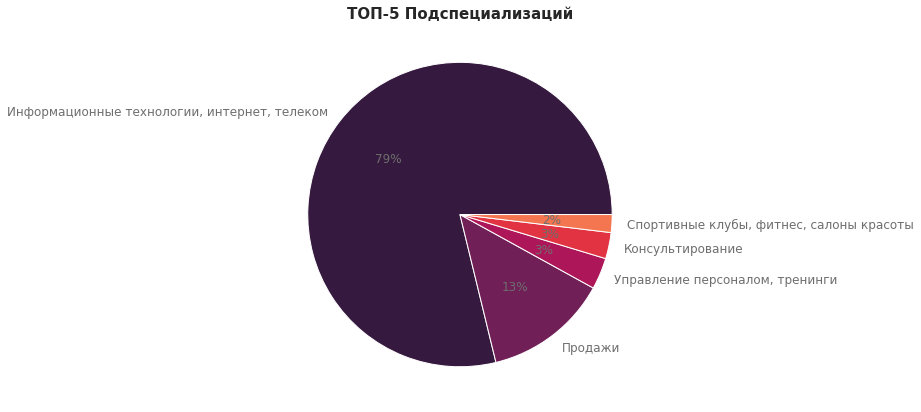

In [68]:
plt.figure(figsize=(7, 7))
plt.pie(subspec[:5], labels = subspec.index[:5], textprops=
        {'fontsize':12, 'color':'#6e6e6e'} , labeldistance=1.1, colors=colors,autopct='%.0f%%')
plt.title('ТОП-5 Подспециализаций', fontweight="bold",fontsize=15)
plt.show()

#                     ВЫВОДЫ:

1.   Мы видим что большее количество вакансий в IT сфере размещено в городе Москва, второе место - Санкт-Петербург , всего городов 664.
2.   ТОП 10 должностей из 11440, на первых двух строчках: Программист 1С и Системный администратор
3.   Из ТОП 15 навыков можно выделить SQL, Git, JavaScript, Linux, 1C
4. ТОП 5 подспециализаций, здесь мы увидели что помимо Топ-1 Информационные технологии, интернет, телеком, требуется подспециализация по топ 2 - Продажи, топ 3 Управление персоналом, тренинги.



# **4. Анализ взаимосвязи колонок**

* Проанализируем заработную плату у ТОП 10 проффессий

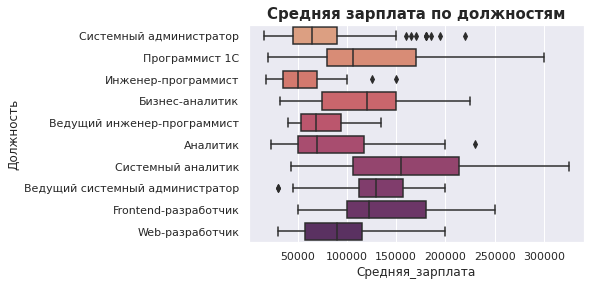

In [70]:
prof = [] # Должность ТОП 10
salar_count = [] # Все зарплаты ТОП 10 Должностей
skill_count = [] # Все навыки ТОП 10 Должностей
subspec_count = [] # Все подспециализации ТОП 10 Должностей


for i in range(len(df['Должность'])):
    try:
        if df['Должность'][i] in proff.index[:10]:
            prof.append(df['Должность'][i])
            salar_count.append(df['Средняя_зарплата'][i])
            skill_count.append(df['Навыки'][i])
            subspec_count.append(df['Подспециализация'][i])
    except:
            pass

            
list_tuples = list(zip(prof,salar_count,skill_count, subspec_count))
dfframe = pd.DataFrame(list_tuples, columns=['Должность','Средняя_зарплата',
                                             'Навыки','Подспециализация'])

sns.set_context("notebook")
plt.title('Средняя зарплата по должностям',fontweight="bold",fontsize=15 )
sns.boxplot(x='Средняя_зарплата', y='Должность',
            data = dfframe.dropna(),palette="flare")
plt.show()


* Сравним зарплаты по подспециализациям

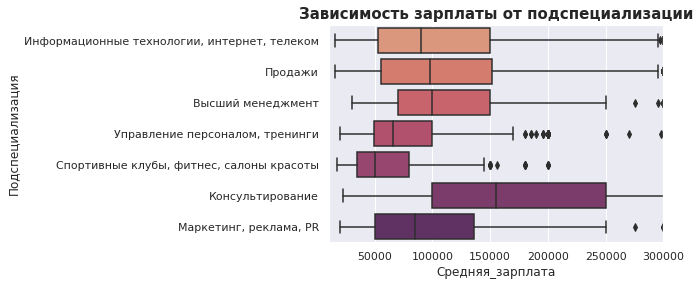

In [71]:
top7 = df['Подспециализация'].value_counts().index
res_top7 = []
for i in range(7):
    res_top7.append(top7[i])
filter = df['Подспециализация'].isin(res_top7)
filtred_df = df[filter]


sns.boxplot(x='Средняя_зарплата', y=filtred_df['Подспециализация'], data = df.dropna(), palette="flare")
plt.title('Зависимость зарплаты от подспециализации',fontweight="bold",fontsize=15)
plt.xlim(10000, 300000)
plt.show()

* Проанализируем наши ТОП 10 вакансий и выделим навыки которые им необходимы.

In [72]:
proff_types = dfframe['Должность'].unique()

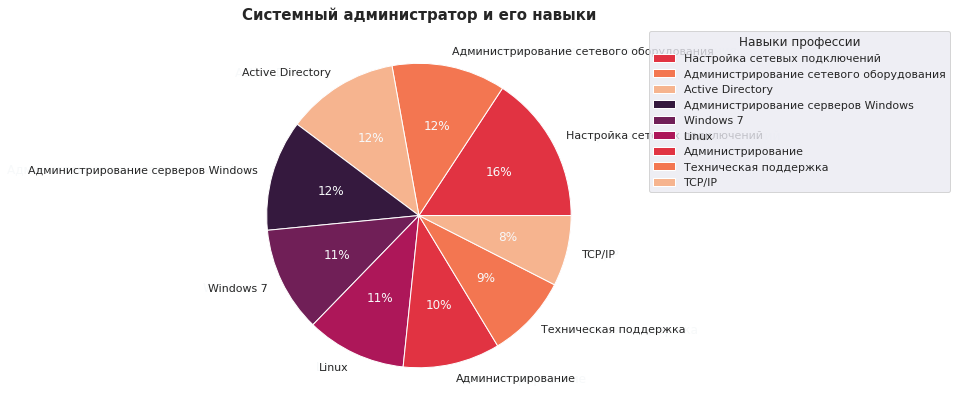

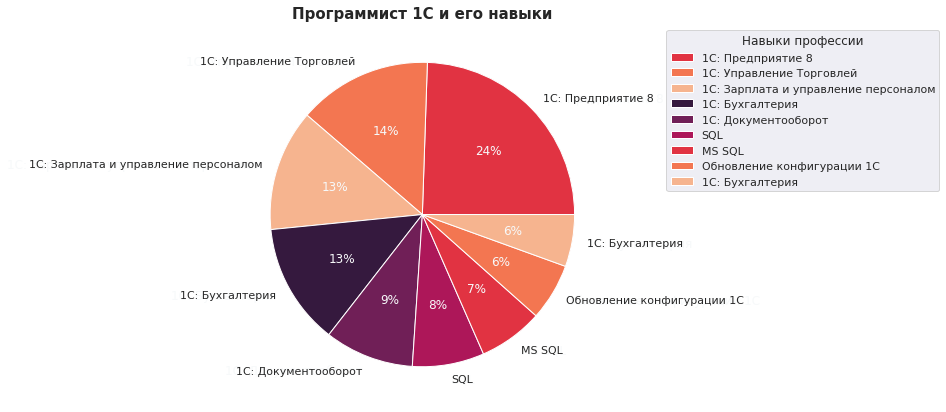

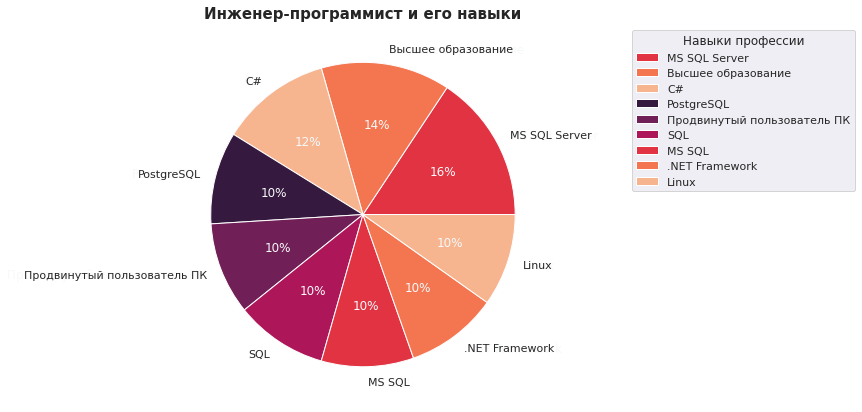

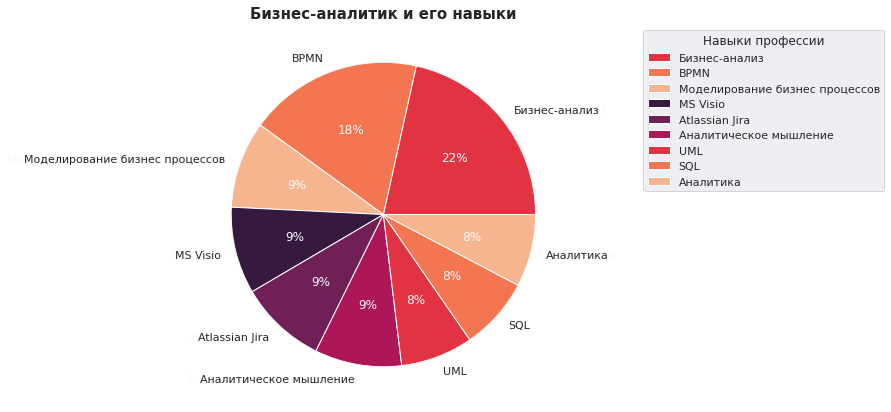

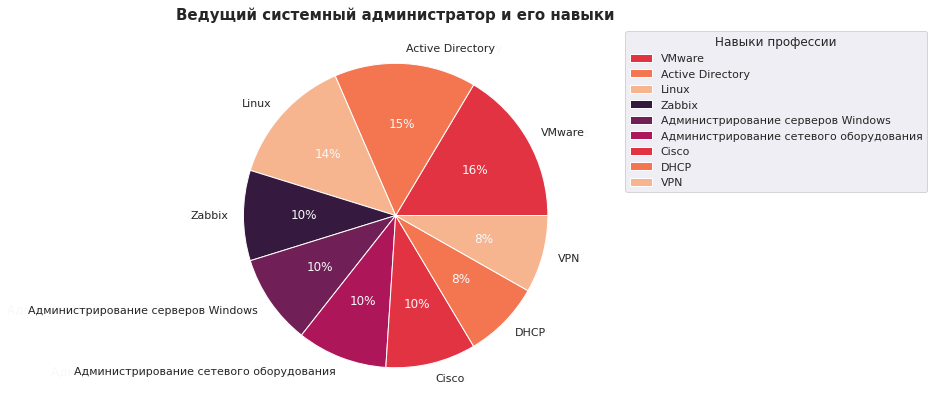

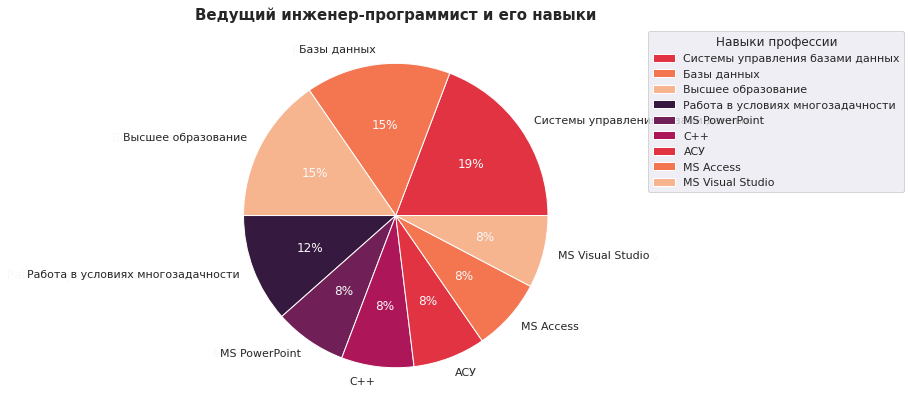

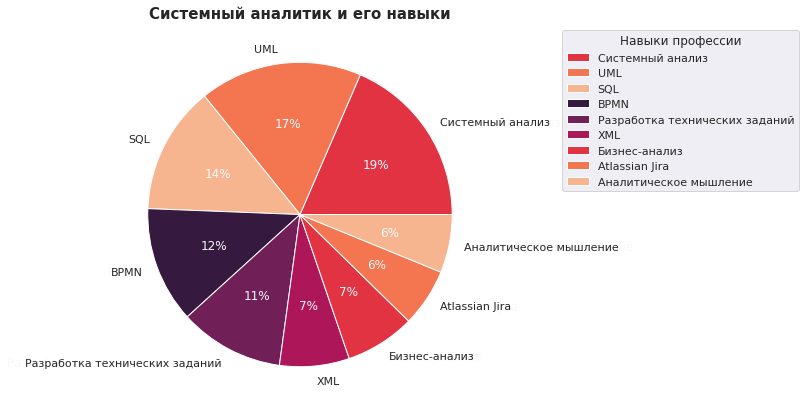

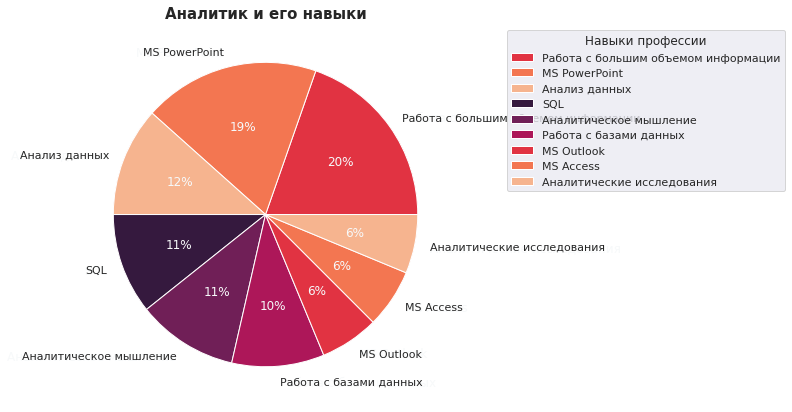

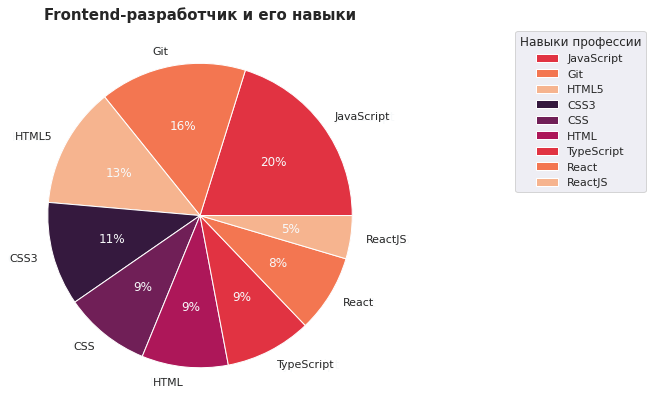

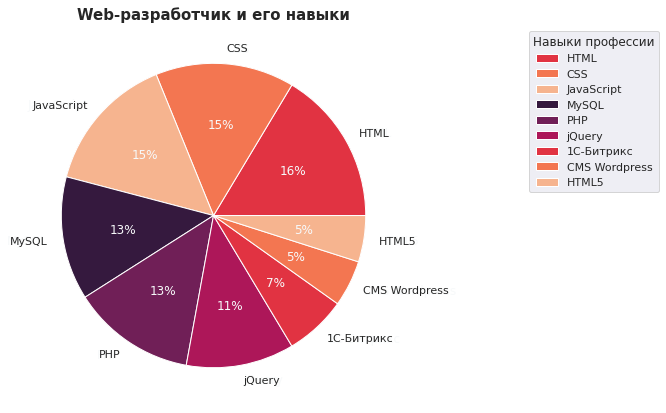

In [73]:
for proffi in proff_types:
  datset = dfframe[dfframe['Должность']==proffi]
  class_counts = datset['Навыки'].explode().value_counts()
  labels = class_counts.index[:9]
  plt.figure(figsize=(7, 7))
  plt.title(f'{proffi} и его навыки',fontweight="bold",fontsize=15)
  plt.pie(class_counts.values[:9], labels = labels,autopct='%.0f%%', textprops=
        {'fontsize':12, 'color':'#f7f9fa'})
  patches, texts = plt.pie(
    class_counts.values[:9], 
    labels = labels
    )
  plt.legend(patches, labels, title="Навыки профессии", loc="upper center", bbox_to_anchor=(1, 0, 1, 1)) 
  plt.show()
  print()

*    Как меняется зарплата с обладанием навыка из ТОП 15

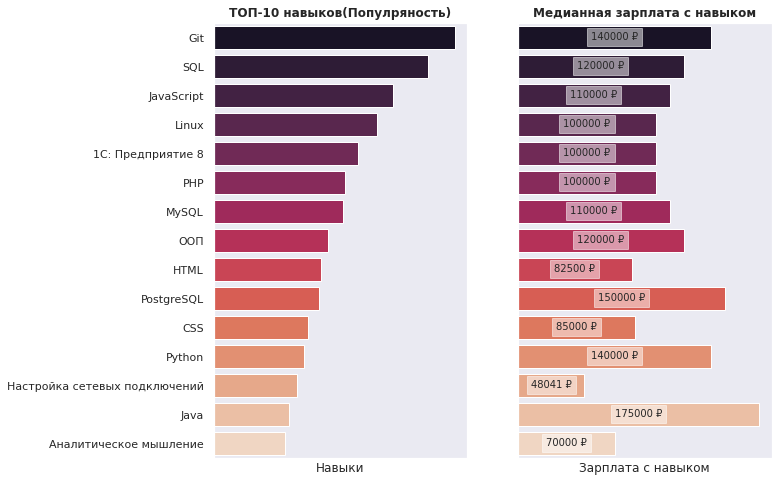

In [75]:
pattern_skill = [i for i in skill.index[:15]]
dict_result = {}
def skill_salary(skill):
    if type(skill) != float:
        return pattern_skill[cnt] in skill
    return False

cnt = 0
for topskill in pattern_skill:
    filter = df['Навыки'].apply(skill_salary).dropna()
    filtred_dataset = df[filter]
    dict_result[topskill] = dict_result.get(topskill, filtred_dataset['Средняя_зарплата'].median())
    cnt += 1
topskill_df = pd.DataFrame.from_dict(dict_result, orient='index')


# sns.set_theme(style="whitegrid", palette="rocket")

f, ax1 = plt.subplots(1, figsize=(10, 8), sharex=True)
x = skill.index[:15]
y1 = skill[:15]

plt.subplot(1, 2, 1)
sns.barplot(y=x, x=y1, palette="rocket")
plt.title('ТОП-10 навыков(Популряность)', fontsize=12, fontweight="bold")
plt.yticks()
plt.xticks(rotation= 90, fontsize=12)
plt.setp(f.axes, xticks=[])
plt.subplot(1, 2, 2)
sns.barplot(x = topskill_df[0].values, y = topskill_df[0].index, palette="rocket")
plt.title('Медианная зарплата c навыком', fontsize=12, fontweight="bold")

ax = sns.barplot(x = topskill_df[0].values, y = topskill_df[0].index, palette="rocket")
rect = ax.patches

labelz = [f"{int(i)} ₽" for i in topskill_df[0].values]
i = -0.65
for rect, label in zip(rect, labelz):
    height = rect.get_height()
    ax.text(
        rect.get_y() + rect.get_width() / 2, height + i, label, ha="center", va="bottom", bbox=dict(facecolor='white', alpha=0.5),
        fontsize=10
    )
    i += 1
plt.xticks([])
plt.xlabel('Зарплата с навыком')
plt.yticks([])
plt.setp(f.axes, xticks=[])
plt.show()

* Заканчиваем очистку датасета, и формируем полностью очищенный файл в формате *.csv для дальнейшего импорта в базу данных PostgreSQL.

In [ ]:
df.drop(df.columns[[0, 1, 2, 3, 4, 5, 6]], axis = 1, inplace=True)
df.to_csv('ITVacant.csv')

# ВЫВОДЫ:



1.   Увидели что по зарплате из наших ТОП 10 лидирует - Frontend Разработчик и Программист 1С, Системный аналитик
2.   Посмотрев заработные платы по подспециализациям, увидели что она не особо влияет на заработную плату, но кроме Консультирования, там зарплаты выше всех остальных категорий.
3.   Увидели для каждой ТОП 10 вакансий и должности, какие необходимо знать технологии и иметь навыки. Ответ на вопрос Чему учить?
4.   Увидели что за такие навыки как: PostgreSQL, Java, Python, GIT работодатели готовы платить больше, если судить по средней заработной плате предлагаемой в вакансиях.
